<a href="https://colab.research.google.com/github/jatinmayekar/ai_project_1/blob/main/point_e_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 1.56 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
%cd point-e

/content/point-e


In [4]:
!pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-hcu4lzdr/clip_660e5ea48f63408d9605269fb2b1f394
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-hcu4lzdr/clip_660e5ea48f63408d9605269fb2b1f394
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=af7b04f864164e369ce5b6e6e393ba024fed7509db12a396e4320f81829cf585
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw6140s9/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.5.0-py

In [5]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 79.3MiB/s]


In [7]:
print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

creating upsample model...


In [8]:
print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

<All keys matched successfully>

In [9]:
print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [10]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [27]:
# Set a prompt to condition on.
prompt = 'small rectangular base'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

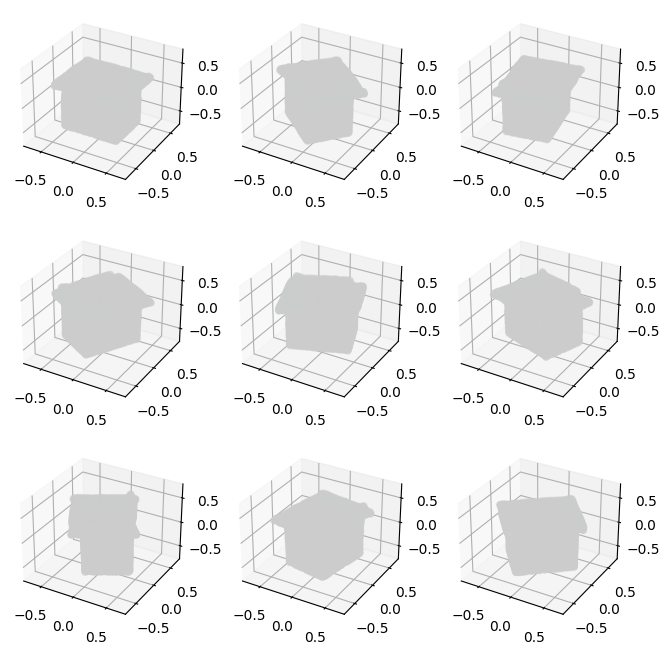

In [28]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [21]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [22]:
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name1 = 'sdf'
model1 = model_from_config(MODEL_CONFIGS[name1], device1)
model1.eval()

print('loading SDF model...')
model1.load_state_dict(load_checkpoint(name1, device1))

creating SDF model...
loading SDF model...


  0%|          | 0.00/38.0M [00:00<?, ?iB/s]

<All keys matched successfully>

In [29]:
# Once pc is generated, convert it to a mesh:
mesh = marching_cubes_mesh(
    pc=pc,
    model=model1,
    batch_size=4096,
    grid_size=32,
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
# Save the mesh as a PLY file:
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

In [31]:
# Optionally, provide a download link for the PLY file in Google Colab:
from google.colab import files
files.download('mesh.ply')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
!pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00


In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interactive


In [34]:
# Create the text box for user input
text_box = widgets.Text(
    value='',
    placeholder='Enter your query',
    description='Query:',
    disabled=False
)

# Create a button that the user can click after entering their prompt
button = widgets.Button(description="Submit")

In [39]:
# Define the action for the button
def on_button_click(b):
    # Retrieve the text prompt entered by the user
    prompt = text_box.value

    # Clear any previous outputs and redisplay the input box and button
    clear_output(wait=True)
    display(text_box, button)

    # Generate point cloud samples based on the provided text prompt
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
        samples = x

    # Convert the samples to a point cloud
    pc = sampler.output_to_point_clouds(samples)[0]

    # Visualize the point cloud
    fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

    # Convert the point cloud to a mesh
    mesh = marching_cubes_mesh(
        pc=pc,
        model=model1,
        batch_size=4096,
        grid_size=32,
        progress=True,
    )

    # Save the mesh as a PLY file
    with open('mesh.ply', 'wb') as f:
      mesh.write_ply(f)

    # Offer the PLY file for download
    from google.colab import files
    files.download('mesh.ply')

In [37]:
# Set the action to the button
button.on_click(on_button_click)

README:

Using the Point Cloud Generation Colab
This Google Colab notebook allows users to generate 3D point clouds based on textual prompts. Users can then convert these point clouds into meshes, which can be saved as PLY files and downloaded for further use.

Instructions:
Entering a Text Prompt:

Find the text box labeled "Query".
Enter a descriptive text (e.g., "a red motorcycle") into the box.
Generate and Download:

After entering your prompt, click the "Submit" button.
The notebook will generate a point cloud based on your prompt, visualize it, convert it into a mesh, and then save it as a PLY file.
A download prompt will appear allowing you to download the generated PLY file.
Use the PLY File:

The downloaded PLY file can be imported into various 3D modeling software or converted to other formats for 3D printing or further processing.
Note: The generation and conversion processes might take a few moments, especially for complex prompts. Please be patient after clicking "Submit".

Text(value='white coffee cup', description='Query:', placeholder='Enter your query')

Button(description='Submit', style=ButtonStyle())

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

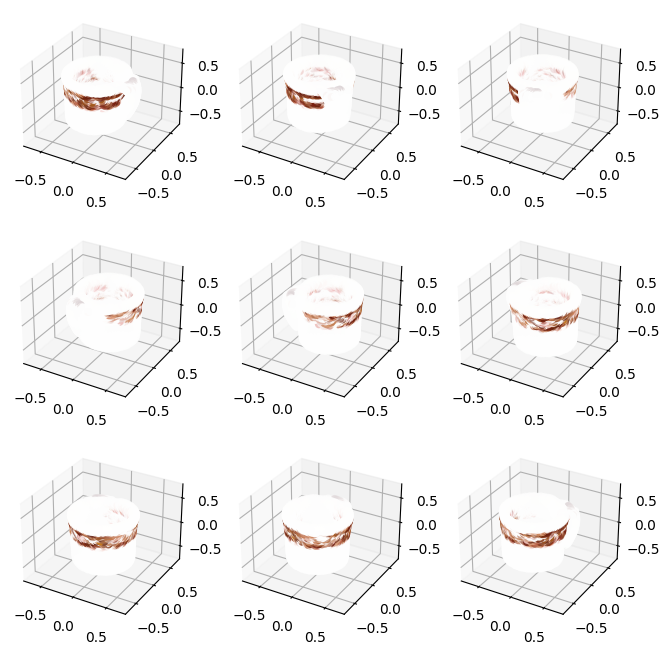

In [38]:
# Display the text box and the button
display(text_box, button)